In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import data_utils

In [3]:
df = data_utils.etl()

In [4]:
current_data = df[df['ingestion_ts'] == max(df['ingestion_ts'])]
sorted_data = current_data.sort_values(by="score", ascending=False)
sorted_data[(sorted_data['price'] > 100) * (sorted_data['price'] < 200)].head(10)

,price,score,deal,num_tickets,section,title,game_ts,ingestion_ts,row
5,126,9.9,Amazing Deal,2,101,Orlando Magic at Philadelphia 76ers,2023-02-02T00:00:00,2023-01-31-11-33-07-450823,11
33,134,9.7,Amazing Deal,2,124,Orlando Magic at Philadelphia 76ers,2023-02-02T00:00:00,2023-01-31-11-33-07-450823,10
43,161,9.6,Amazing Deal,4,Club Box 14,Orlando Magic at Philadelphia 76ers,2023-02-02T00:00:00,2023-01-31-11-33-07-450823,B
2,198,9.6,Amazing Deal,1-3,110,Memphis Grizzlies at Philadelphia 76ers,2023-02-24T00:30:00,2023-01-31-11-33-07-450823,11
10,120,9.6,Amazing Deal,2,203,New York Knicks at Philadelphia 76ers,2023-02-11T00:00:00,2023-01-31-11-33-07-450823,2
10,177,9.5,Amazing Deal,2,123,Cleveland Cavaliers at Philadelphia 76ers,2023-02-16T00:00:00,2023-01-31-11-33-07-450823,5
17,154,9.5,Amazing Deal,2,104,Boston Celtics at Philadelphia 76ers,2023-04-05T00:00:00,2023-01-31-11-33-07-450823,16
0,146,9.5,Amazing Deal,5,111,Miami Heat at Philadelphia 76ers,2023-04-06T23:30:00,2023-01-31-11-33-07-450823,12
47,163,9.5,Amazing Deal,2,Club Box 2,Orlando Magic at Philadelphia 76ers,2023-02-02T00:00:00,2023-01-31-11-33-07-450823,B
1,191,9.5,Amazing Deal,5,111,Miami Heat at Philadelphia 76ers,2023-04-06T23:30:00,2023-01-31-11-33-07-450823,1


In [14]:
sections_of_interest = ['124', '101', '102', '114', '113', '112']

best_deals = df[df['score'] == 10.0]
best_sections = best_deals[best_deals['section'].apply(lambda x: x in sections_of_interest)]

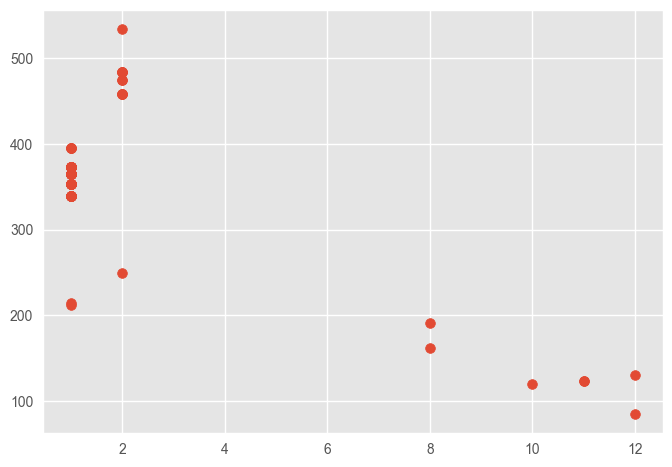

In [34]:
plt.scatter(best_sections['row'].astype('int'), best_sections['price'])
plt.show()